In [1]:
#os to check that the input is valid
ruta = 'C:/Users/alejo/Downloads/RedLat/EEG Standarization - BrainLat/fdr_finalFeatures_HC__VS__SQZ.csv'
import os
if not os.path.isfile(ruta):
    print('ERROR: The file entered by parameter does not exist')
    #return

In [2]:
#Installs required modules, if the file does exist
!pip install mlxtend==0.18.0
!pip install xgboost
!pip install plotly==5.5.0
!pip install shap
!pip install -U kaleido

In [3]:
#Imports required packages
#Pandas for loading the .csv
import pandas as pd

#train_test_split for spliting the data
from sklearn.model_selection import train_test_split

#mlxtend for feature selection and xgboost for the machine learning model
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBClassifier
import xgboost as xgb

#plt for plotting feature importance
import matplotlib.pyplot as plt

#Multiple packages for evaluating the model performance
import numpy as np
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

#SHAP for feature importance
import shap

#Stratified K-Fold for CV and creating ROC curves
from sklearn.model_selection import StratifiedKFold

In [4]:
#Loads the desired .csv
subj = pd.read_csv(ruta)
subj

,Diagnostic,Precentral_L__VS__Calcarine_L___ham_dist,Frontal_Sup_R__VS__Temporal_Sup_R___ham_dist,Rectus_R__VS__ParaHippocampal_R___ham_dist,Cingulum_Mid_L__VS__Cingulum_Post_L___ham_dist,Calcarine_L__VS__Occipital_Sup_L___ham_dist,Calcarine_L__VS__Occipital_Mid_L___ham_dist,Calcarine_L__VS__Occipital_Inf_L___ham_dist,Lingual_L__VS__Lingual_R___ham_dist,Precentral_L__VS__Calcarine_L___mimat,...,Parietal_Inf_L__VS__Angular_R___cmimat,Parietal_Inf_L__VS__Precuneus_R___cmimat,SupraMarginal_R__VS__Temporal_Mid_R___cmimat,SupraMarginal_R__VS__Temporal_Inf_L___cmimat,Angular_L__VS__Temporal_Mid_R___cmimat,Angular_R__VS__Heschl_R___cmimat,Temporal_Sup_R__VS__Temporal_Inf_R___cmimat,Temporal_Mid_R__VS__Temporal_Inf_L___cmimat,Precentral_L__VS__Calcarine_L___omat,Frontal_Sup_R__VS__Temporal_Sup_R___omat
0,HC,0.819712,0.714371,0.405998,0.414129,0.402987,0.532688,0.414492,0.558579,1.121541,...,0.012065,0.017699,-1.526766e-06,0.000016,0.000102,3.112432e-05,5.925302e-04,6.670383e-03,0.749848,0.599224
1,HC,0.734882,0.609101,0.446619,0.425154,0.460453,0.581815,0.446431,0.575216,0.746359,...,0.004168,0.005600,9.575117e-06,0.000144,0.000017,3.241727e-07,-7.313436e-07,6.670675e-03,0.322584,0.309024
2,HC,0.761753,0.666249,0.466410,0.434660,0.468279,0.581634,0.441421,0.554796,0.820688,...,0.003390,0.005831,5.878472e-06,0.000015,0.000104,2.005652e-05,5.358128e-05,2.662286e-03,0.400593,0.427472
3,HC,0.733656,0.652772,0.409593,0.395103,0.406985,0.499666,0.398588,0.498076,0.788470,...,0.003879,0.001436,-3.215528e-06,0.000122,0.000024,-1.543488e-06,3.636146e-04,2.436615e-04,0.416374,0.479792
4,HC,0.802575,0.685729,0.416426,0.396213,0.415187,0.549572,0.399023,0.555600,1.010435,...,0.000299,0.000579,3.035831e-05,0.000003,-0.000003,1.092970e-04,5.505604e-06,1.317962e-03,0.469783,0.466453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,SQZ,0.790382,0.709083,0.433953,0.430611,0.432434,0.563711,0.449156,0.541714,1.019403,...,0.002640,0.002171,1.064323e-05,0.000365,0.000648,3.436680e-05,2.550515e-04,4.373641e-04,0.600092,0.580157
65,SQZ,0.797118,0.654589,0.426270,0.416945,0.422389,0.563030,0.426361,0.583561,1.072733,...,0.005205,0.003471,3.974386e-05,0.000298,0.000569,2.799708e-04,3.706380e-05,3.032480e-04,0.616519,0.401886
66,SQZ,0.789655,0.686657,0.466047,0.425536,0.429975,0.489653,0.413058,0.505188,0.928727,...,0.002009,0.006250,9.147419e-07,0.000296,0.000018,1.836522e-04,3.753539e-05,1.765025e-03,0.551354,0.422521
67,SQZ,0.720075,0.577117,0.409243,0.396972,0.403383,0.553316,0.404610,0.577267,0.696046,...,0.005908,0.003432,1.280726e-05,-0.000002,0.000278,6.627481e-08,5.616203e-06,6.317094e-05,0.245031,0.206973


In [5]:
#Replaces the output category names for numbers rather than strings
X = subj
y = X.iloc[:,0]
y_labels = pd.unique(y)
if len(y_labels) > 2:
    print('ERROR: Expected a maximum of 2 classes in the first column')
    print('The first column MUST be the output variable (diagnostic, group, etc). For this file it is called: ' + subj.columns[0])
    print('And its unique values are: ' + str(y_labels))
    raise Exception("Wrong column name or wrong number of classes_diagnostics_groups")
    #return
          
for idx, uniqueLabel in enumerate(y_labels):
    y = y.replace(uniqueLabel, idx)

X = X.drop(X.columns[[0]], axis=1)

In [6]:
#Splits data into stratified training and test sets (80/20)
rng = np.random.RandomState(2022)     #Defines a seed to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train

,Precentral_L__VS__Calcarine_L___ham_dist,Frontal_Sup_R__VS__Temporal_Sup_R___ham_dist,Rectus_R__VS__ParaHippocampal_R___ham_dist,Cingulum_Mid_L__VS__Cingulum_Post_L___ham_dist,Calcarine_L__VS__Occipital_Sup_L___ham_dist,Calcarine_L__VS__Occipital_Mid_L___ham_dist,Calcarine_L__VS__Occipital_Inf_L___ham_dist,Lingual_L__VS__Lingual_R___ham_dist,Precentral_L__VS__Calcarine_L___mimat,Frontal_Sup_R__VS__Temporal_Sup_R___mimat,...,Parietal_Inf_L__VS__Angular_R___cmimat,Parietal_Inf_L__VS__Precuneus_R___cmimat,SupraMarginal_R__VS__Temporal_Mid_R___cmimat,SupraMarginal_R__VS__Temporal_Inf_L___cmimat,Angular_L__VS__Temporal_Mid_R___cmimat,Angular_R__VS__Heschl_R___cmimat,Temporal_Sup_R__VS__Temporal_Inf_R___cmimat,Temporal_Mid_R__VS__Temporal_Inf_L___cmimat,Precentral_L__VS__Calcarine_L___omat,Frontal_Sup_R__VS__Temporal_Sup_R___omat
26,0.707460,0.611262,0.403883,0.397238,0.401696,0.505752,0.415375,0.528392,0.774429,0.432851,...,0.000428,0.002529,8.721262e-06,1.064880e-04,1.035361e-04,1.431197e-04,1.246597e-05,1.015918e-03,0.358481,0.413489
57,0.773777,0.686001,0.429521,0.430241,0.434718,0.558280,0.448702,0.553907,0.873089,0.495690,...,0.000656,0.000981,-3.023056e-06,1.325258e-04,3.081993e-04,2.207217e-05,8.733657e-06,2.312523e-04,0.389916,0.474370
23,0.746556,0.620996,0.431714,0.426951,0.430384,0.534401,0.440980,0.576118,0.805534,0.354196,...,0.003655,0.006665,2.602073e-05,2.160021e-04,-3.072821e-06,8.536109e-05,1.296321e-04,1.936650e-03,0.346430,0.337098
0,0.819712,0.714371,0.405998,0.414129,0.402987,0.532688,0.414492,0.558579,1.121541,0.607353,...,0.012065,0.017699,-1.526766e-06,1.631279e-05,1.015735e-04,3.112432e-05,5.925302e-04,6.670383e-03,0.749848,0.599224
60,0.773414,0.673926,0.403474,0.402624,0.398361,0.517763,0.400418,0.531870,0.895731,0.474140,...,0.001697,0.001278,2.009896e-06,3.524107e-05,2.739373e-04,-3.109414e-06,-3.042831e-06,4.437891e-03,0.377491,0.454272
39,0.786184,0.640904,0.426004,0.417529,0.420449,0.563666,0.424394,0.580531,1.043729,0.394856,...,0.004974,0.001629,6.083639e-05,1.630160e-04,6.712125e-04,4.785641e-04,9.642269e-06,2.330643e-04,0.550377,0.350454
17,0.805235,0.718238,0.401398,0.413921,0.392145,0.512864,0.425900,0.557482,1.015925,0.621201,...,0.000087,0.016124,3.455675e-05,1.376410e-04,2.187164e-04,1.251633e-04,6.768369e-04,4.396278e-03,0.556559,0.600680
51,0.722145,0.589407,0.405797,0.401307,0.391593,0.455191,0.393111,0.499854,0.696135,0.288635,...,0.005943,0.011859,-2.784945e-06,8.852793e-05,8.117434e-05,1.374728e-05,1.363937e-06,1.137183e-06,0.189290,0.245678
13,0.791933,0.693574,0.409866,0.408977,0.405512,0.512163,0.406057,0.573808,1.000166,0.571041,...,0.007232,0.012749,-1.721152e-06,5.583597e-04,3.173391e-05,5.209433e-04,4.297611e-04,9.398166e-04,0.473425,0.517894
5,0.775866,0.674730,0.478681,0.443933,0.476734,0.590504,0.445542,0.558403,0.904102,0.488140,...,0.010797,0.010629,-3.216370e-06,6.662563e-05,-3.094368e-06,4.079014e-05,6.721379e-05,2.404449e-03,0.491670,0.471119


In [7]:
#Trains a XGBoosting classifier and performs feature importance analysis
lr = XGBClassifier(random_state=42, seed = 2022)

sfs = SFS(lr, 
          k_features="best", 
          forward=True, 
          floating=False, 
          scoring='f1',
          verbose=2,
          cv=5,
          n_jobs = -1)

sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:   17.6s finished

[2022-01-28 13:53:02] Features: 1/107 -- score: 0.6976190476190476[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   16.4s finished

[2022-01-28 13:53:18] Features: 2/107 -- score: 0.7866666666666666[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   17.0s finished

[2022-01-28 13:53:36] Features: 3/107 -- score: 0.7257720057720058[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 104 ou

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   11.8s finished

[2022-01-28 13:59:44] Features: 31/107 -- score: 0.6699999999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   11.2s finished

[2022-01-28 13:59:55] Features: 32/107 -- score: 0.682121212121212[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   10.5s finished

[2022-01-28 14:00:06] Features: 33/107 -- score: 0.6866666666666666[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   11.1s finished

[2022-01-28 14:00:17] Features: 34/1

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    7.0s finished

[2022-01-28 14:04:32] Features: 62/107 -- score: 0.6835353535353536[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished

[2022-01-28 14:04:39] Features: 63/107 -- score: 0.6835353535353536[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    6.7s finished

[2022-01-28 14:04:46] Features: 64/107 -- score: 0.6835353535353536[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    6.4s finished

[2022-01-28 14:04:52] Features: 65/

[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.2s finished

[2022-01-28 14:07:03] Features: 94/107 -- score: 0.5888888888888889[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    1.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.1s finished

[2022-01-28 14:07:06] Features: 95/107 -- score: 0.5831746031746032[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    1.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.9s finished

[2022-01-28 14:07:08] Features: 96/107 -- score: 0.5920634920634921[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    1.2s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   8

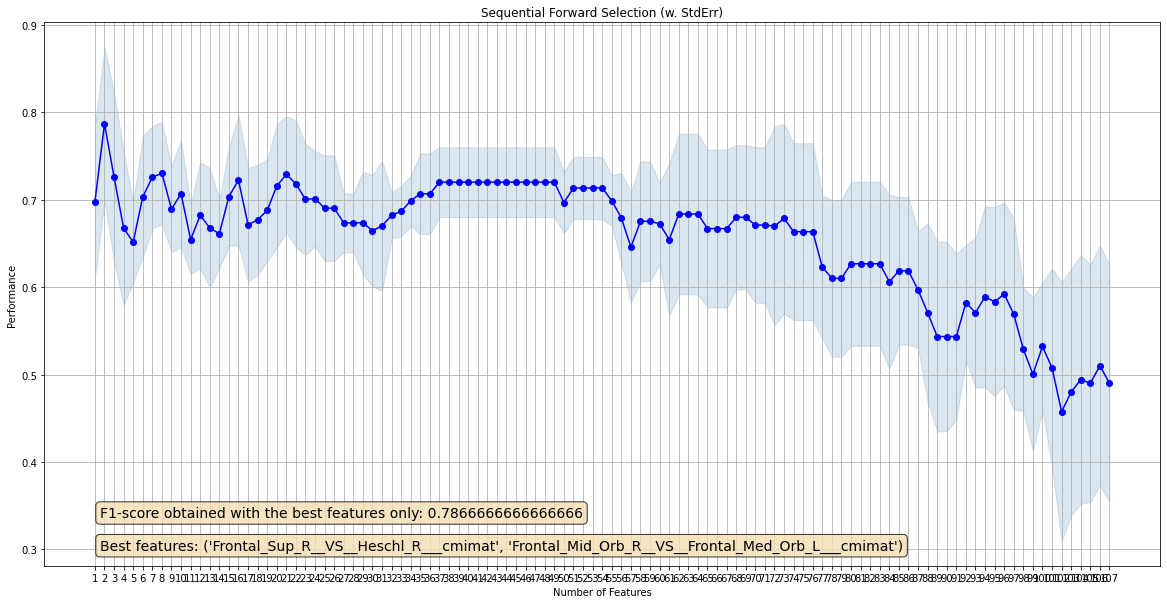

In [8]:
#PLots feature importance
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')

#Adds some info about the most important features, as well as the best F1-score
txt1 = ('Best features: ' + str(sfs.k_feature_names_))
txt2 = ('F1-score obtained with the best features only: ' + str(sfs.k_score_))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place text box 1 in bottom left in axes coords
ax.text(0.05, 0.05, txt1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# place text box 2 in bottom left in axes coords
ax.text(0.05, 0.11, txt2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.grid()
plt.show()
#fig.savefig('AllFeaturesImportance.jpg', bbox_inches='tight')

In [9]:
#Defines new subsets ONLY with the most important features in the test set
lista = list(sfs.k_feature_names_)

Xsel = X_test[lista]
Xsel
print(np.shape(Xsel))

#Xsel = X_train[lista]
#Xsel_test = X_test[lista]
#print(np.shape(Xsel_test))

(14, 2)


In [13]:
#Defines folds divisions for cross-validation in the test set
cv_n_splits = 5
cv    = StratifiedKFold(n_splits=cv_n_splits, shuffle = True, random_state = 42)
folds = [(train,test) for train, test in cv.split(Xsel, y_test)]
#folds = [(train,test) for train, test in cv.split(Xsel, y_train)]
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}


In [14]:
#Defines parameters for XGBoosting Cross-Validation models
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss'
}

In [15]:
#Creates XGBoosting Cross-Validation models, and saves the ROC curve
plt.rcParams["figure.figsize"] = (10,10)
dtest = xgb.DMatrix(Xsel, label=y_test)
#dtest = xgb.DMatrix(Xsel_test, label=y_test)
print('Test labels: ' + str(dtest.get_label()))
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(Xsel.iloc[train,:], label=y_test.iloc[train])
    #dtrain = xgb.DMatrix(Xsel.iloc[train,:], label=y_train.iloc[train])
    print('Training labels: ' + str(dtrain.get_label()))
    
    dval   = xgb.DMatrix(Xsel.iloc[test,:], label=y_test.iloc[test])
    #dval   = xgb.DMatrix(Xsel.iloc[test,:], label=y_train.iloc[test])
    print('Validation labels: ' + str(dval.get_label()))
    
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    print(results.keys())
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))
kind = 'test'
c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(4):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 600,
    height      = 600,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')

#fig.write_image("ROC_Curve.jpg")

Test labels: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]


Training labels: [0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
Validation labels: [0. 0. 1.]
dict_keys(['train', 'val', 'test'])
Training labels: [0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
Validation labels: [1. 0. 0.]
dict_keys(['train', 'val', 'test'])
Training labels: [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
Validation labels: [0. 0. 1.]
dict_keys(['train', 'val', 'test'])
Training labels: [0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.]
Validation labels: [0. 1. 0.]
dict_keys(['train', 'val', 'test'])
Training labels: [0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
Validation labels: [0. 1.]
dict_keys(['train', 'val', 'test'])



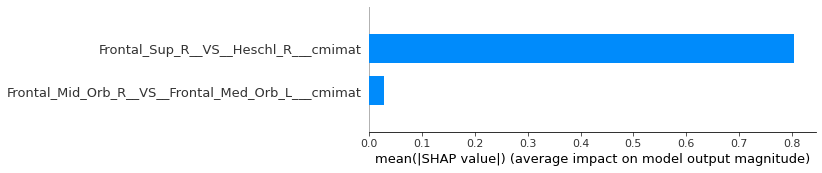

In [13]:
#Executes SHAP for feature importance and saves the figure
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xsel)
shap.summary_plot(shap_values, Xsel, plot_type="bar", show=False)
fig = plt.gcf()
#fig.savefig('SHAP_BestFeaturesImportance.jpg', bbox_inches='tight')